# Week 3 - Domain Generalization

This notebook is written to recreate experiments from [In Search of Lost Domain Generalization](https://arxiv.org/abs/2007.01434). In this paper, the authors introduce a framework for benchmarking new domain generalization algorithms. We will be examining some of these algorithms in more detail on some of the datasets used in the paper.

In [25]:
%matplotlib inline
from torchvision.datasets import MNIST
from domainbed.scripts.download import *
from domainbed import datasets, algorithms, hparams_registry
from domainbed.lib import misc
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from domainbed.lib.fast_data_loader import InfiniteDataLoader, FastDataLoader
import json

## Import required datasets

In [4]:
# CHANGE THIS PATH TO YOUR DATA DIRECTORY
base_path = '/research/labs/microbiome/chia/data/herbert_domainBed/'
full_path = stage_path(base_path, 'MNIST')

In [3]:
# ONLY NEED TO RUN ONCE TO DOWNLOAD MNIST DATASET
MNIST(full_path, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:04<00:00, 2.04MB/s]


Extracting /research/labs/microbiome/chia/data/herbert_domainBed/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to /research/labs/microbiome/chia/data/herbert_domainBed/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 776kB/s]


Extracting /research/labs/microbiome/chia/data/herbert_domainBed/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to /research/labs/microbiome/chia/data/herbert_domainBed/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 983kB/s] 


Extracting /research/labs/microbiome/chia/data/herbert_domainBed/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to /research/labs/microbiome/chia/data/herbert_domainBed/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 995kB/s]


Extracting /research/labs/microbiome/chia/data/herbert_domainBed/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to /research/labs/microbiome/chia/data/herbert_domainBed/MNIST/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: /research/labs/microbiome/chia/data/herbert_domainBed/MNIST
    Split: Train

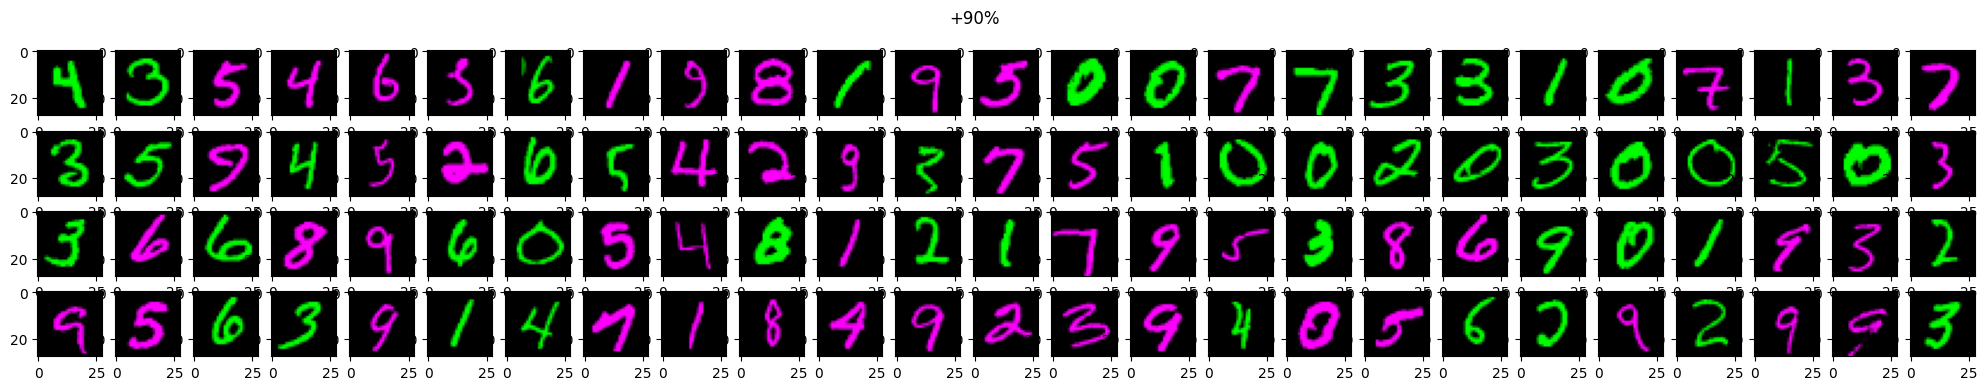

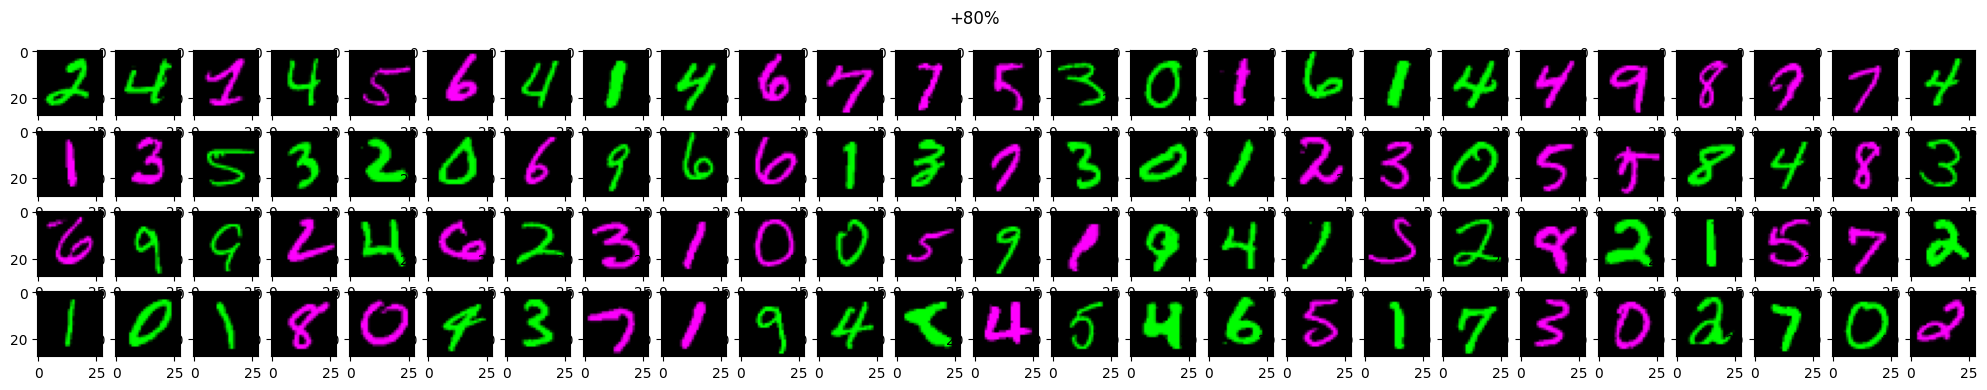

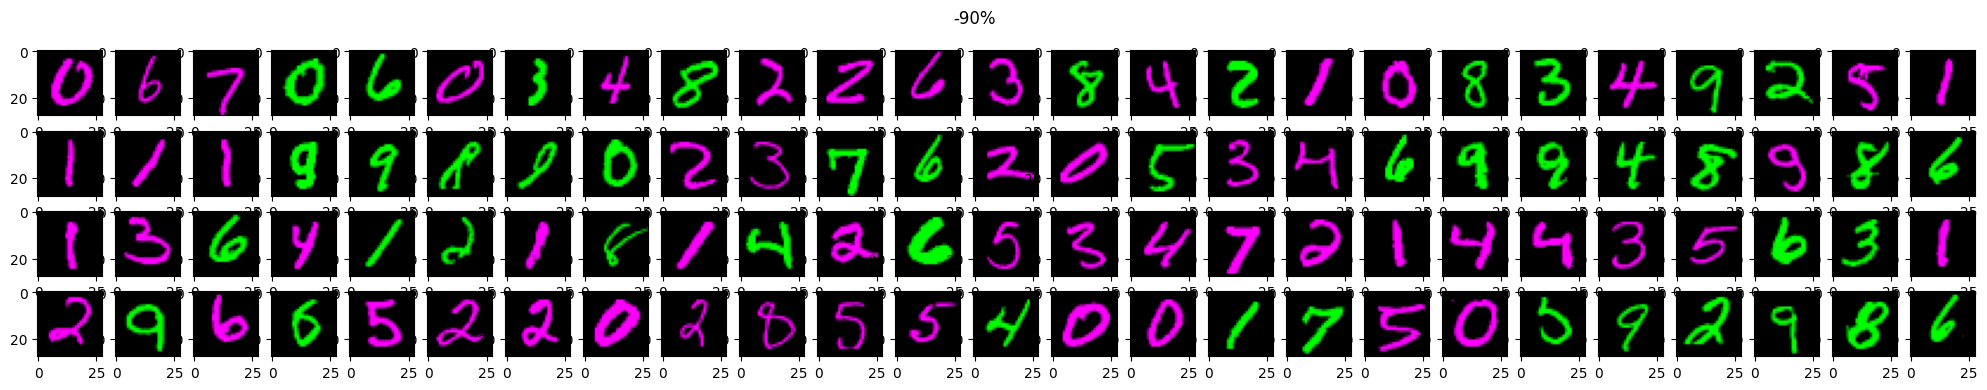

In [10]:
coloredMNIST_dataset = vars(datasets)['ColoredMNIST'](full_path, None, None)
for j, color_label_corr in enumerate(['+90%', '+80%', '-90%']):
    fig,ax = plt.subplots(4,25, figsize=(25,4))
    ax = ax.flatten()
    for i in range(100):
        image = coloredMNIST_dataset[j][i][0].permute(1,2,0)
        image = image.numpy()
        rgb_image = np.stack(np.stack((image[:, :, 0], image[:, :, 1], image[:, :, 0]), axis=-1))
        ax[i].imshow(rgb_image)
    fig.suptitle(color_label_corr)

When plotting the first 100 examples of the colored MNIST dataset, we can see the differences in the domains. The domains are defined by the correlation between a color and a label. Each digit label has its own unique level of color correlation. More information on the way this is calculated can be seen in the dataset.py file and the [original colored MNIST paper](https://arxiv.org/abs/1907.02893). Any model attempting to classify digits will tend to exploit color rather than the actual image. We then reverse the correlation during model testing so we can identify how much of what the model is learning is based on color. By teaching the model to ignore color, the original colored MNIST authors hoped to improve domain generalization.

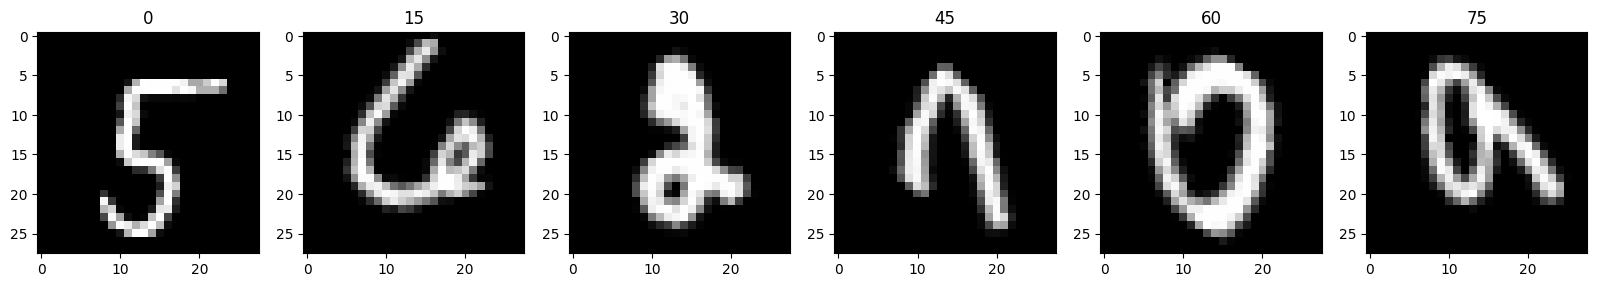

In [5]:
rotatedMNIST_dataset = vars(datasets)['RotatedMNIST'](full_path, None, None)    
fig,ax = plt.subplots(1,6, figsize=(20,5))
for j, color_label_corr in enumerate([i for i in range(0,76,15)]):
    image = rotatedMNIST_dataset[j][0][0].permute(1,2,0)
    image = image.numpy()
    ax[j].imshow(image, cmap='gray')
    ax[j].set_title(color_label_corr)

We can see in the rotated MNIST dataset that even when a rotation is applied, the way that the number was originally written can cause it to appear at a different angle. Therefore, a high performing character classifier should be agnostic to any rotations. The application of domain generalization is rooted in actual challenges of the original dataset. 

## Exercise 1

Choose an alternative dataset from DomainBed (not coloredMNIST or rotatedMNIST) and display the differences in the domains of that dataset. Examples can be seen in Table 3 of the paper. Describe how they define different domains. Comment on potential obstacles when learning in those different domains that a domain generalization algorithm would have to remedy.

In [90]:
# TODO: Your solution here.

## Training and testing domain generalization algorithms

Below, we will walk through exactly what is happening in the train.py file. DomainBed has implemented model training on the command line, but it's important to understand where our inputs are being used.

In order to train a domain generalization model, we need to define the hyperparameters. Luckily, DomainBed implements defaults for each algorithm.

In [6]:
hparams = hparams_registry.default_hparams('ERM', 'RotatedMNIST')
for key,value in hparams.items():
    print(key,value) 

data_augmentation True
resnet18 False
resnet50_augmix True
dinov2 False
vit False
vit_attn_tune False
freeze_bn False
lars False
linear_steps 500
resnet_dropout 0.0
vit_dropout 0.0
class_balanced False
nonlinear_classifier False
lr 0.001
weight_decay 0.0
batch_size 64


Below is a recreation (with some components removed so it works in our notebook) of how the dataset is loaded in train.py. In splits are the training data and evaluation is performed on all data, but we can consider the out_split to be our test data. Facebook is using proprietary DataLoaders that wrap original PyTorch dataloaders. These can be found in lib/fast_data_loader.py if you're interested in their implementation.

In [7]:
in_splits = []
out_splits = []
holdout_fraction = 0.2
trial_seed = 61598
test_envs = [0]
for env_i, env in enumerate(rotatedMNIST_dataset): 

    out, in_ = misc.split_dataset(env,
        int(len(env)*holdout_fraction),
        misc.seed_hash(trial_seed, env_i))

    if hparams['class_balanced']:
        in_weights = misc.make_weights_for_balanced_classes(in_)
        out_weights = misc.make_weights_for_balanced_classes(out)

    else:
        in_weights, out_weights, uda_weights = None, None, None
    in_splits.append((in_, in_weights))
    out_splits.append((out, out_weights))

train_loaders = [InfiniteDataLoader(
    dataset=env,
    weights=env_weights,
    batch_size=hparams['batch_size'],
    num_workers=1)
    for i, (env, env_weights) in enumerate(in_splits)
    if i not in test_envs]

eval_loaders = [FastDataLoader(
    dataset=env,
    batch_size=64,
    num_workers=1)
    for env, _ in (in_splits + out_splits)]
eval_weights = [None for _, weights in (in_splits + out_splits)]
eval_loader_names = ['env{}_in'.format(i)
    for i in range(len(in_splits))]
eval_loader_names += ['env{}_out'.format(i)
    for i in range(len(out_splits))]


DomainBed implements the different DG algorithms in the algorithms.py file through the get_algorithm_class function. Simply pass the name of the algorithm to this function and then initialize using our dataset.

In [9]:
algorithm_class = algorithms.get_algorithm_class('ERM')
algorithm = algorithm_class(rotatedMNIST_dataset.input_shape, rotatedMNIST_dataset.num_classes, len(rotatedMNIST_dataset), hparams)
algorithm

ERM(
  (featurizer): MNIST_CNN(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn0): GroupNorm(8, 64, eps=1e-05, affine=True)
    (bn1): GroupNorm(8, 128, eps=1e-05, affine=True)
    (bn2): GroupNorm(8, 128, eps=1e-05, affine=True)
    (bn3): GroupNorm(8, 128, eps=1e-05, affine=True)
    (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
    (activation): Identity()
  )
  (classifier): Linear(in_features=128, out_features=10, bias=True)
  (network): Sequential(
    (0): MNIST_CNN(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(

We can see that, by using the structure of our inputs and hyperparameters, the algorithm method has built our neural network. In their function, the neural network is built from a featurizer (the backbone of the CNN) and a classifier (the final layer appended to the CNN for calculating output). The algorithm function also contains an update method that calculates our gradients and performs backpropagation.

In [10]:
# Create minibatches iterator and perform an update step on a single batch
train_minibatches_iterator = zip(*train_loaders)
device = 'cpu'
minibatches_device = [(x.to(device), y.to(device))
            for x,y in next(train_minibatches_iterator)]
step_vals = algorithm.update([minibatches_device[0]], None)
print(step_vals)

{'loss': 2.3260834217071533}


Note: If we run this block of code multiple times, we will see that the loss changes. This is due to the next() python function where minibatches are called. Each time next() is called on the minibatches iterator, it pulls the next minibatch. 

Now that we know what's going on behind the scenes when a dataset and algorithm are chosen, we can try reproducing some results from the paper and doing a bit of a deeper dive. The README.md file contains instructions for running a simple model training example. This can also be seen on the [github for DomainBed](https://github.com/facebookresearch/DomainBed) from which this assignment is forked. The results below are for 3 algorithms - ERM, ERM++, and Mixup - run on the RotatedMNIST dataset.

⚠️ CLEAR THE TRAIN_OUTPUT DIRECTORY BEFORE YOU RUN YOUR EXPERIMENTS. IT CURRENTLY CONTAINS THE DATA USED TO MAKE THE EXAMPLE PLOTS ⚠️

Results at step 5000:


,0,15,30,45,60,75
ERM,0.987141,0.990141,0.990141,0.991856,0.989713,0.990141
ERM++,0.982426,0.989713,0.986712,0.990141,0.986712,0.987141
Mixup,0.986712,0.988856,0.990141,0.992285,0.990570,0.986284


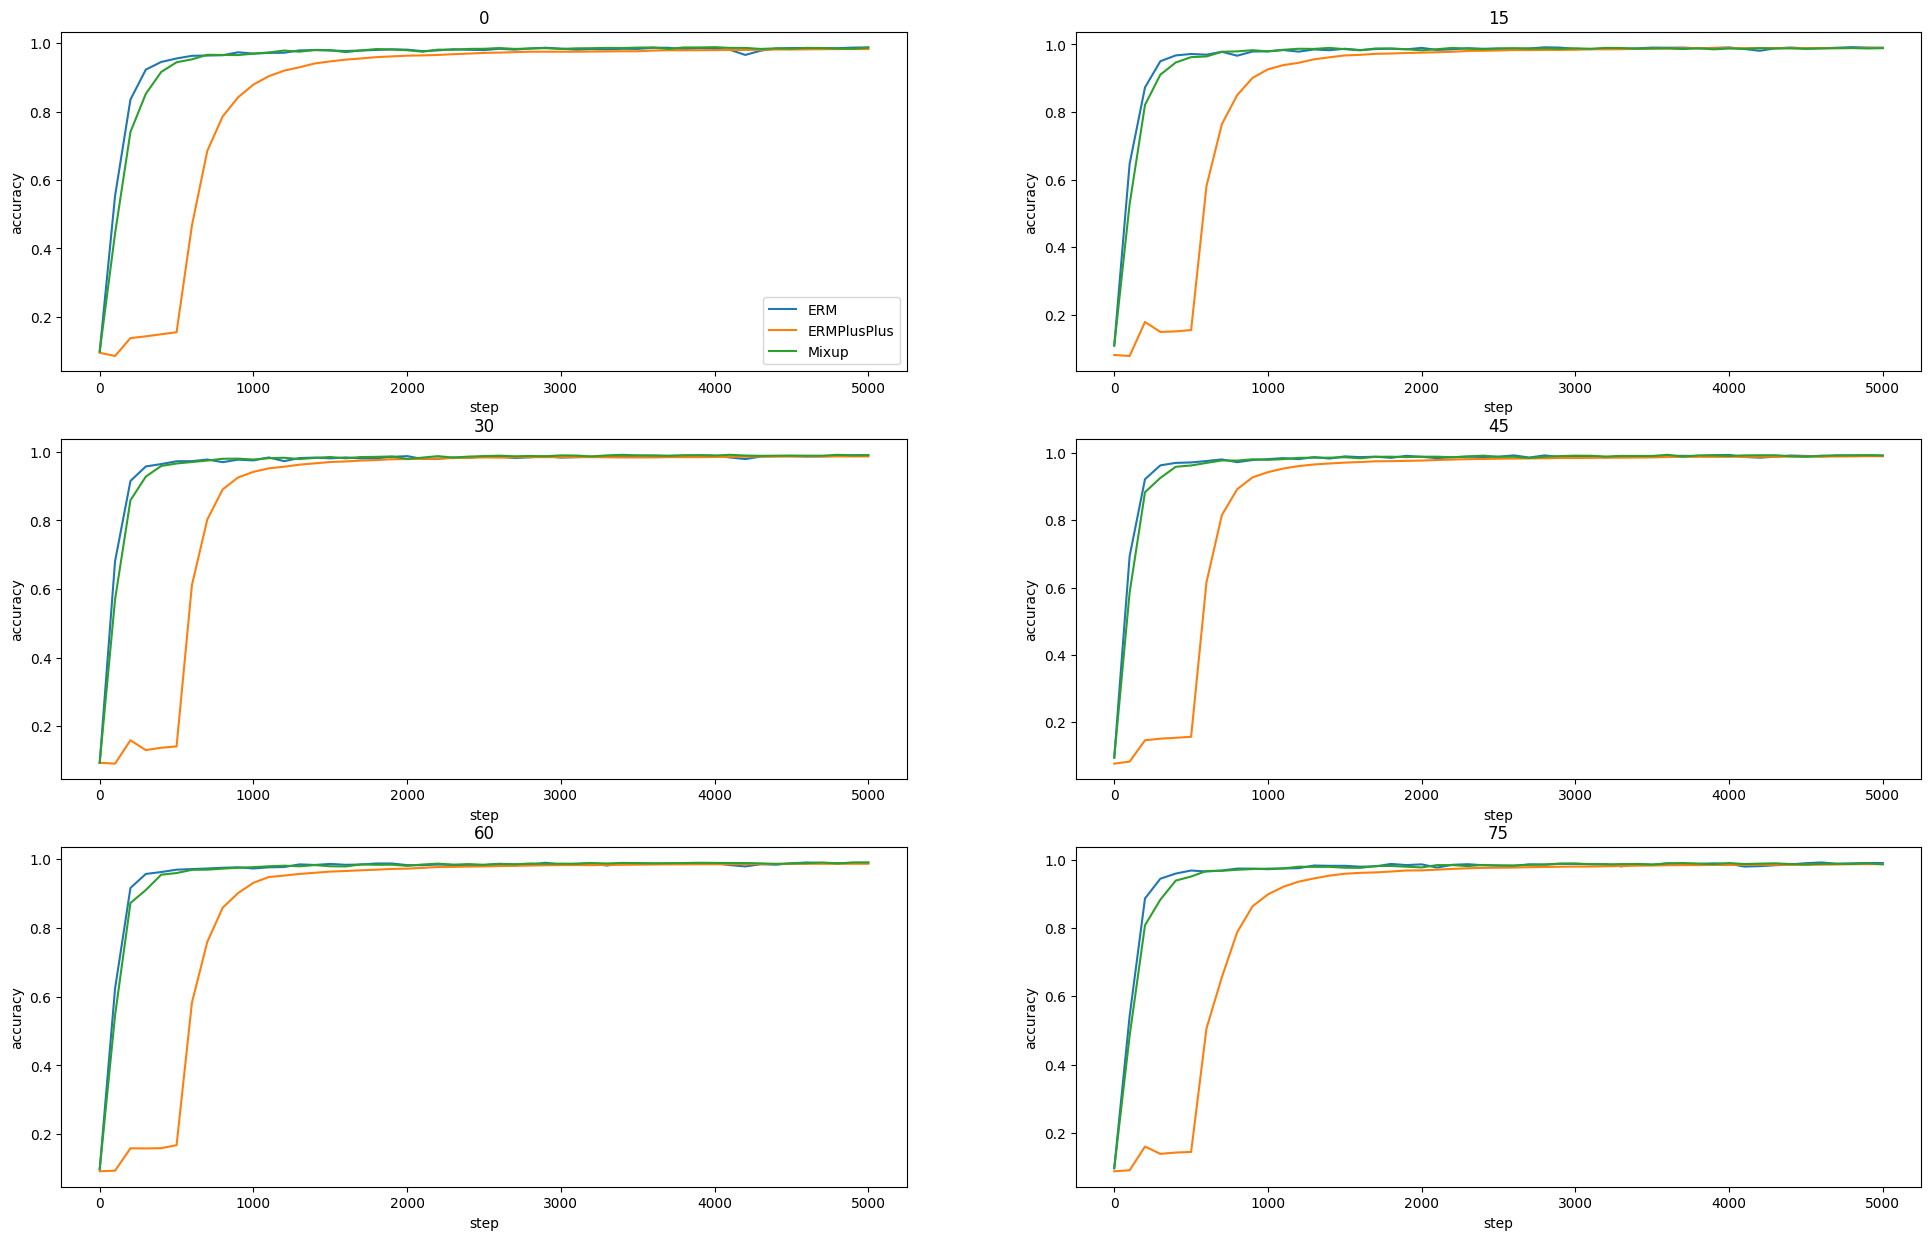

In [36]:
# Plot out_split loss vs. step for all 6 domains across three algorithms.
fig,axs = plt.subplots(3,2, figsize=(24,15))
with open('train_output/results.jsonl') as f:
    data = [json.loads(line) for line in f]

results_dict = {}
for entry in data:
    curr_algo = entry['args']['algorithm']
    if curr_algo not in results_dict.keys():
        results_dict[curr_algo] = [[] for _ in range(6)]
    for i in range(6):
        results_dict[curr_algo][i].append((entry['step'],entry[f'env{i}_out_acc']))
ax = axs.flatten()
for val in results_dict.values():
    for j,env in enumerate(val):
        x,y = zip(*env)
        ax[j].plot(x,y)
        ax[j].set_xlabel('step')
        ax[j].set_ylabel('accuracy')
        ax[j].set_title(f'{15*j}')

ax[0].legend(results_dict.keys())

# Create table of performance at last step during training
df = pd.DataFrame([[results_dict[key][i][-1][1] for i in range(6)] for key in results_dict.keys()])
df.index = ['ERM', 'ERM++', 'Mixup']
df.columns = [i*15 for i in range(6)]
print('Results at step 5000:')
df

We can see that the results at the final step for all three algorithms are comparable matches with what was seen in the DomainBed paper. When plotting accuracy over time, however, it becomes clear that ERM converges to an optimal solution faster than either of the other two algorithms. This is an important distinction since ERM++ is advertised as an improved version of ERM. RotatedMNIST is not one of the datasets tested in the [original ERM++ paper](https://arxiv.org/abs/2304.01973).

## Exercise 2

On the dataset you chose for Exercise 1, train and test at least 3 different domain generalization algorithms. Plot results below and comment on performance. If you chose one of the same datasets they tested, do your results match what was seen in the original paper? Based on the different algorithms and the unique domain challenges presented by your dataset, are these results expected? This may require a deeper dive on the details of the algorithms you implemented.

In [11]:
# TODO: Your plots here.

## Modifying existing domain generalization algorithms

Examining the implementation of DG algorithms in the algorithms.py file reveals their simplicity. For example, ERM is just the loss calculated across all domains at once. DomainBed provides an accessible testing ground for modifications of these algorithms. For example, we can change ERM from calculating loss across all domains to using an average of each domain's loss. This is implemented in algorithms.py as ERMAverage.

Results at step 5000:


,0,15,30,45,60,75
ERM,0.987141,0.990141,0.990141,0.991856,0.989713,0.990141
ERMAverage,0.984998,0.990141,0.990141,0.993999,0.989713,0.989284


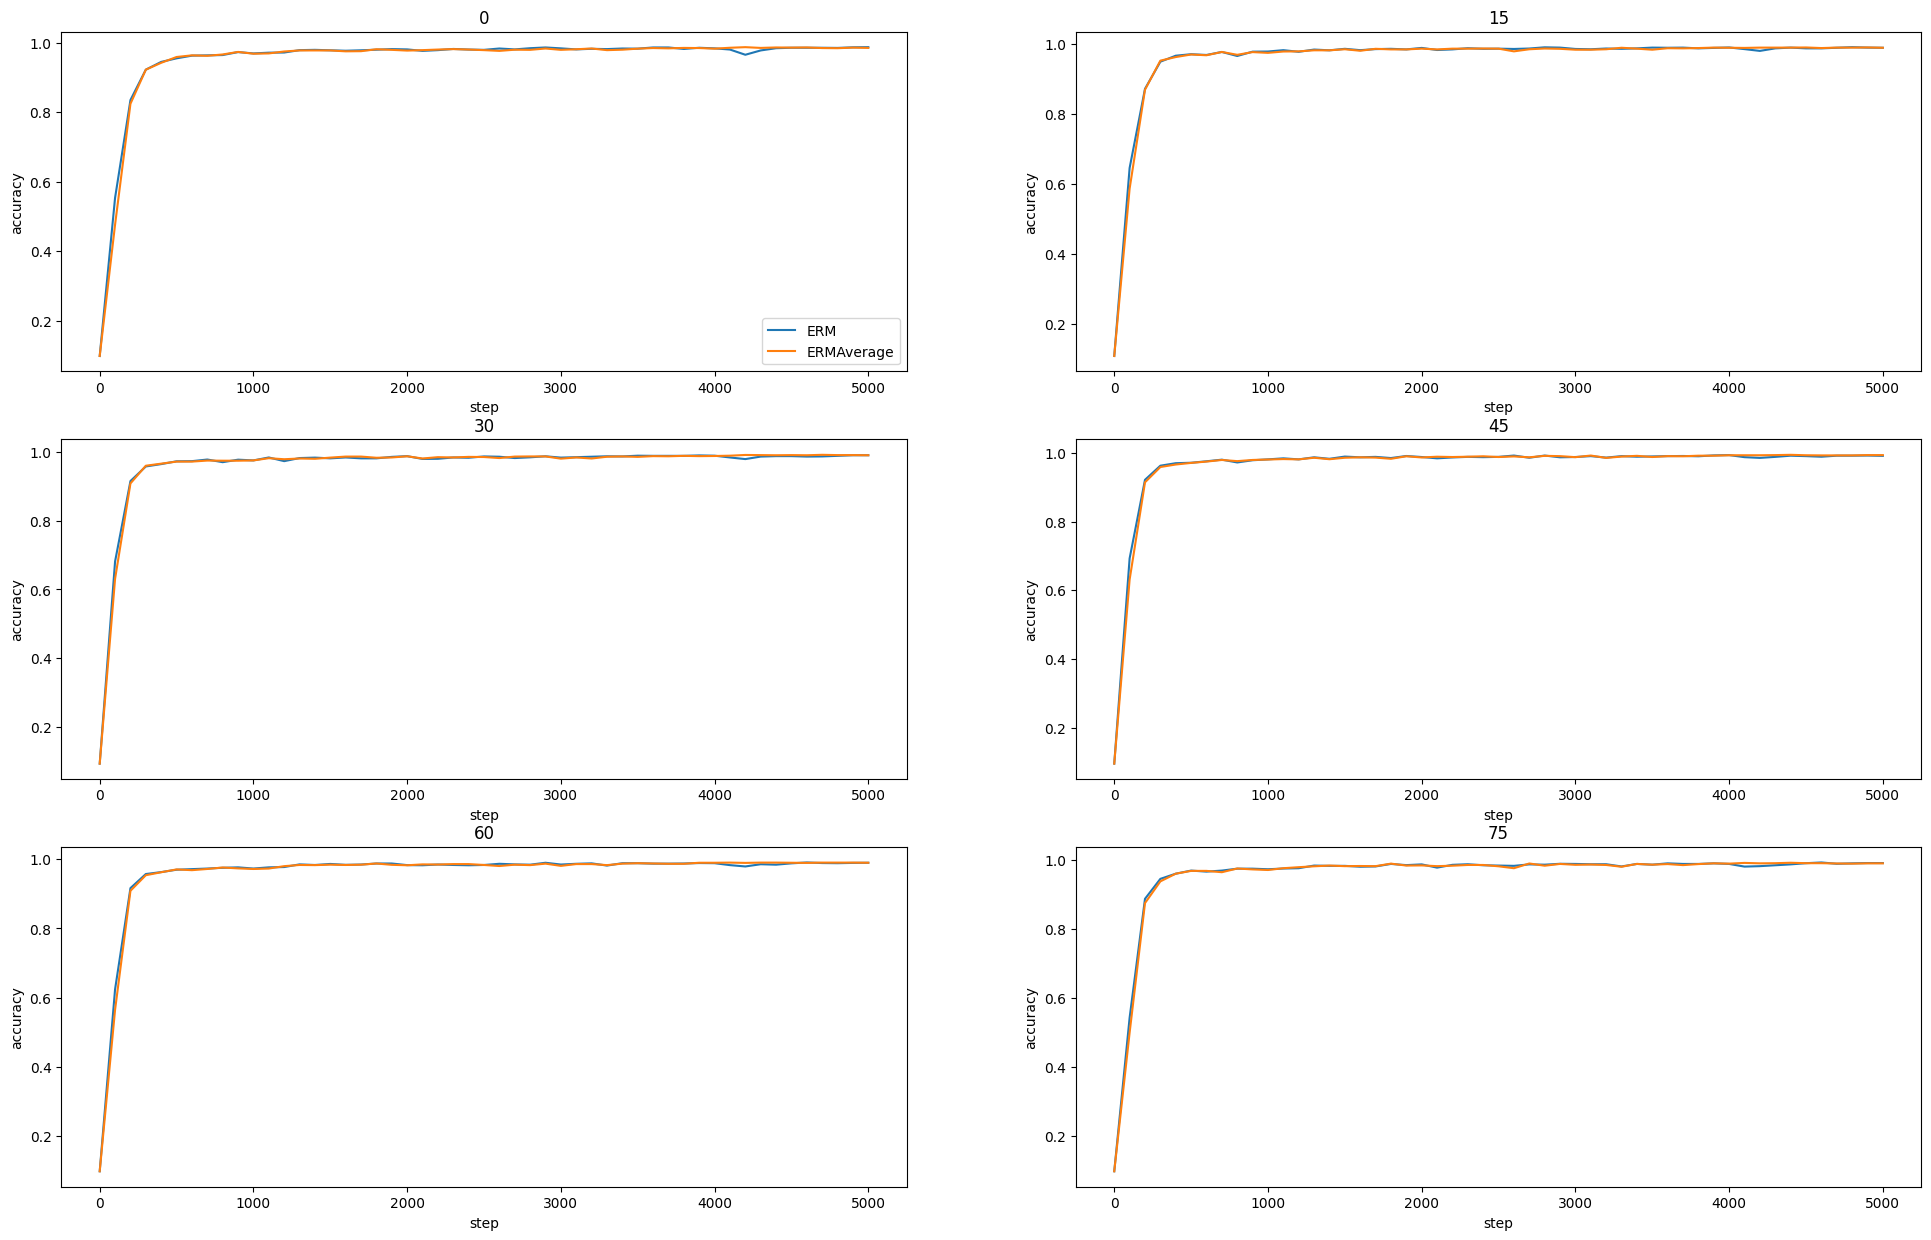

In [43]:
# Plot out_split loss vs. step for all 6 domains across three algorithms.
fig,axs = plt.subplots(3,2, figsize=(24,15))
with open('train_output/results.jsonl') as f:
    data = [json.loads(line) for line in f]

results_dict = {}
for entry in data:
    curr_algo = entry['args']['algorithm']
    if curr_algo not in results_dict.keys() and (curr_algo == 'ERM' or curr_algo == 'ERMAverage'):
        results_dict[curr_algo] = [[] for _ in range(6)]
    if curr_algo == 'ERM' or curr_algo == 'ERMAverage':
        for i in range(6):
            results_dict[curr_algo][i].append((entry['step'],entry[f'env{i}_out_acc']))
ax = axs.flatten()
for val in results_dict.values():
    for j,env in enumerate(val):
        x,y = zip(*env)
        ax[j].plot(x,y)
        ax[j].set_xlabel('step')
        ax[j].set_ylabel('accuracy')
        ax[j].set_title(f'{15*j}')

ax[0].legend(results_dict.keys())

# Create table of performance at last step during training
df = pd.DataFrame([[results_dict[key][i][-1][1] for i in range(6)] for key in results_dict.keys()])
df.index = ['ERM', 'ERMAverage']
df.columns = [i*15 for i in range(6)]
print('Results at step 5000:')
df

We expected moving from full loss to average loss to damage performance, but overall it does not degrade performance by very much. The start up is slightly slower than normal ERM but reaches the same accuracy. By results, RotatedMNIST appears to be one of the easier domain generalization problems, so perhaps this would degrade performance more in another DG dataset.

## Exercise 3

With whatever algorithm and dataset you would like, make at least 1 change and examine how this impacts performance. For example, you can change how loss is calculated, remove certain components to determine their essentiality, or create your own DG algorithm. Implement your solution in algorithms.py and copy the function to a code block below with comments added in where changes were made. Plot your results and explain any differences (or lack thereof). 

In [ ]:
# TODO: Your solution here.